# __The Kronos Incident__

#### __Client Report: 24-01-001__

___GeoJusticeLabs___ is an innovative consultancy that aims to bridge the gap between data and justice. We specialise in geographic approaches to data science and have a long history of providing rapid and discrete advice to our partners in law enforcement. We use a rigorous, scientific approach to our investigations, including pre-registering our hypotheses, which focuses our data exploration on your problem, rather than what we know or are good at. Ethical considerations are made throughout our research process. 

## __Table of Contents__
1. Business understanding and initial hypotheses
1. Data understanding
1. Data preparation and further hypotheses
1. Modelling
1. Evaluation and final hypotheses
1. Recommendations to law enforcement

## __Business Understanding__

__Client and stakeholders__. GasTech has been successfully operating on the island of Kronos for twenty years. It has led by __Sten Sanjorge Jr (CEO)__, supported by a team of four executives. Ingrid Barranco (CFO) and Ada Campo-Corrente (CIO) are our key stakeholders and sponsors

__Problem area__. Several employees are missing and ___GeoJusticeLabs___ is commissioned to support the law enforcement investigation. Explicitly, we are to use datasets provided by the client to generate insights; implicitly, we are to do this quickly and with tact to avoid generating further negative publicitly. 

__Background research__. Our own research into the general problem of kidnappings and disappearences shows that they are overwhelmingly related to financial and family problems. These findings are what have informed our initial hypotheses. 

__Objectives and success criteria__. Tentatively, our research will be judged a success if it narrows down the problem and investigatory space for local law enforcement by more than two-thirds. 

__Ethics and risks__. There are significant risks that in conducting and sharing this analysis we reveal the personnel data of employees to GasTech and law enforcement. To migitate this, we will take steps to anonymise data where possible.

__Data wrangling goals__. Tentatively, data wrangling will be successful if it can support clustering of employees into affinity groups and identify patterns of life from travel and spending.

## Initial Hypotheses

___GeoJusticeLabs___ makes the following initial hypotheses to guide its initial exploratory data analysis and establish a pattern of life for the island. 

H1. Customer transactions will correlate with time of day and will highest around mealtimes and social times. 

H2. Given the small size of the island and community, there are limited products and services on offer and therefore transactions will be limited to a narrow range of $5-500.

H3. Transactions will be unevenly distributed and cluster around one of more popular outlets. 

## Data Understanding

### Gather initial data

In [47]:
# Install required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime as dt

# For ethics, encryption, and anonymisation
# from cryptography.fernet import Fernet

# For visualisation
import seaborn as sns

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load relevant datasets
creditCard = pd.read_csv('cc_data.csv', encoding='ISO-8859-1')
loyaltyCard = pd.read_csv('loyalty_data.csv', encoding='ISO-8859-1')
carAssignments = pd.read_csv('car-assignments.csv', encoding='ISO-8859-1')
gps = pd.read_csv('gps.csv', encoding = 'ISO-8859-1')

__(NB: in this section I had intended to import and use the cryptography library to encrypt employee names. Despite being installed in the environment, I could not get it to work in the notebook)__

### Basic data inspection

In [48]:
creditCard.head()

,timestamp,location,price,last4ccnum
0,01/06/2014 07:28,Brew've Been Served,11.34,4795
1,01/06/2014 07:34,Hallowed Grounds,52.22,7108
2,01/06/2014 07:35,Brew've Been Served,8.33,6816
3,01/06/2014 07:36,Hallowed Grounds,16.72,9617
4,01/06/2014 07:37,Brew've Been Served,4.24,7384


In [49]:
loyaltyCard.head()

,timestamp,location,price,loyaltynum
0,01/06/2014,Brew've Been Served,4.17,L2247
1,01/06/2014,Brew've Been Served,9.60,L9406
2,01/06/2014,Hallowed Grounds,16.53,L8328
3,01/06/2014,Coffee Shack,11.51,L6417
4,01/06/2014,Hallowed Grounds,12.93,L1107


In [50]:
carAssignments.head()

,LastName,FirstName,CarID,CurrentEmploymentType,CurrentEmploymentTitle
0,Calixto,Nils,1.0,Information Technology,IT Helpdesk
1,Azada,Lars,2.0,Engineering,Engineer
2,Balas,Felix,3.0,Engineering,Engineer
3,Barranco,Ingrid,4.0,Executive,SVP/CFO
4,Baza,Isak,5.0,Information Technology,IT Technician


In [51]:
gps.head()

,Timestamp,id,lat,long
0,01/06/2014 06:28:01,35,36.076225,24.874689
1,01/06/2014 06:28:01,35,36.076220,24.874596
2,01/06/2014 06:28:03,35,36.076211,24.874443
3,01/06/2014 06:28:05,35,36.076217,24.874253
4,01/06/2014 06:28:06,35,36.076214,24.874167


After we've developed a feel for the structure of our data, we'll inspect the summary statistics for numeric columns. For now, we can drop the carAssignments and GPS datasets as their values are predominantly non-numeric. 

In [52]:
creditCard.describe()

,price,last4ccnum
count,1490.000000,1490.000000
mean,207.696530,5827.863758
std,740.855467,2729.332956
min,2.010000,1286.000000
25%,15.127500,3484.000000
50%,28.240000,6895.000000
75%,67.177500,8129.000000
max,10000.000000,9735.000000


In [53]:
loyaltyCard.describe()

,price
count,1392.000000
mean,204.333915
std,719.013783
min,3.000000
25%,13.130000
50%,22.845000
75%,38.215000
max,4983.520000


### Check for and address missing values 

In [54]:
creditCard.isnull().sum()

timestamp     0
location      0
price         0
last4ccnum    0
dtype: int64

In [55]:
loyaltyCard.isnull().sum()

timestamp     0
location      0
price         0
loyaltynum    0
dtype: int64

In [56]:
carAssignments.isnull().sum()

LastName                  0
FirstName                 0
CarID                     9
CurrentEmploymentType     0
CurrentEmploymentTitle    0
dtype: int64

In [57]:
gps.isnull().sum()

Timestamp    0
id           0
lat          0
long         0
dtype: int64

### Data types and memory optimisation

We've developed an understanding of the structure of our datasets and the shape of the numerical values. Finally, we'll inspect the datatypes and memory usage of each dataframe to understand where we can optimise memory usage. 

In [58]:
creditCard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1490 non-null   object 
 1   location    1490 non-null   object 
 2   price       1490 non-null   float64
 3   last4ccnum  1490 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 46.7+ KB


In [59]:
loyaltyCard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1392 non-null   object 
 1   location    1392 non-null   object 
 2   price       1392 non-null   float64
 3   loyaltynum  1392 non-null   object 
dtypes: float64(1), object(3)
memory usage: 43.6+ KB


In [60]:
carAssignments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LastName                44 non-null     object 
 1   FirstName               44 non-null     object 
 2   CarID                   35 non-null     float64
 3   CurrentEmploymentType   44 non-null     object 
 4   CurrentEmploymentTitle  44 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.8+ KB


In [61]:
gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685169 entries, 0 to 685168
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Timestamp  685169 non-null  object 
 1   id         685169 non-null  int64  
 2   lat        685169 non-null  float64
 3   long       685169 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 20.9+ MB


## Explore data

The preceding steps have given us a good understanding of the kinds of transformations the data requires. Before we do that, let's do some basic exploratory work against the hypotheses we pre-registered. 

In [62]:
# Convert credit card and gps timestamp columns to datetime. 
creditCard['timestamp'] = pd.to_datetime(creditCard['timestamp'])
gps['Timestamp'] = pd.to_datetime(gps['Timestamp'])

#### H1. Transaction frequency will correlate with time of day and will be highest around mealtimes and social times.

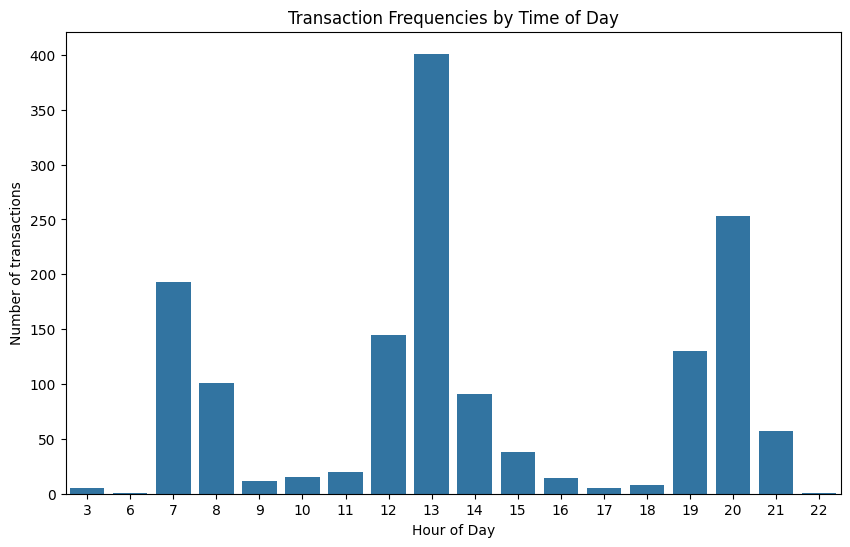

In [63]:
# Extract hour from the timestamp
creditCard['hour'] = creditCard['timestamp'].dt.hour

# Group by hour and count transactions
transaction_by_hour = creditCard.groupby('hour').size()

# Plot the result
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=creditCard)
plt.title('Transaction Frequencies by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of transactions')
plt.show()

This appears to support our hypotheses, but let's look at the data another way to check.

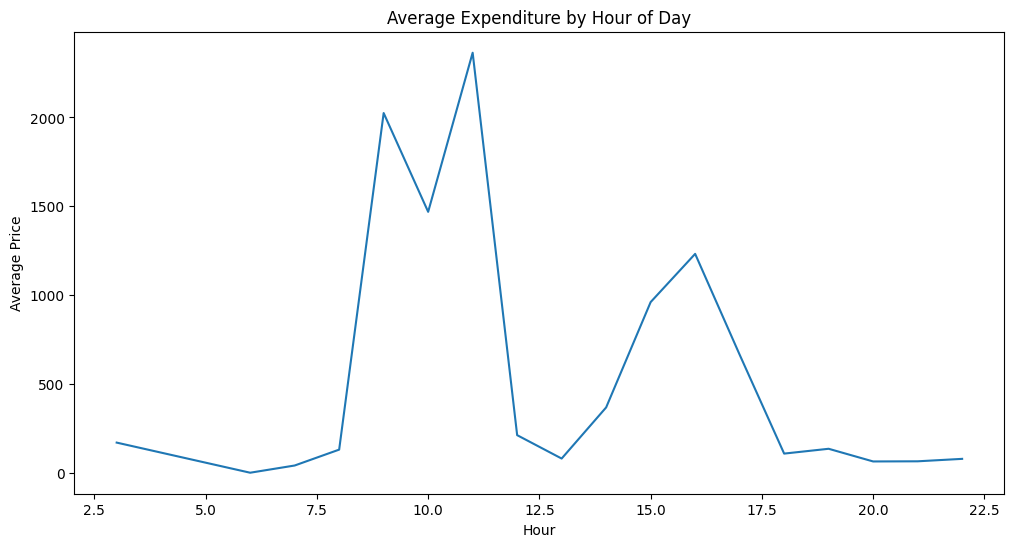

In [64]:
# How does spending change by hour of day?
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='price', data=creditCard, estimator='mean', errorbar=None)
plt.title('Average Expenditure by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Price')
plt.show()

H1 is __supported__. It raises questions about the pattern of life and spending patterns outside of these popular times, particularly at 0300. 

#### H2. Given the size of the island and community, there are limited products and services on offer to consumers: transactions will be within a narrow range (< $500). 

In [65]:
# Reviewing the summary statistics for transactions.
creditCard['price'].describe()

count     1490.000000
mean       207.696530
std        740.855467
min          2.010000
25%         15.127500
50%         28.240000
75%         67.177500
max      10000.000000
Name: price, dtype: float64

This has told us that there is an enormous skew to the values. So, let's look at the data another way. 

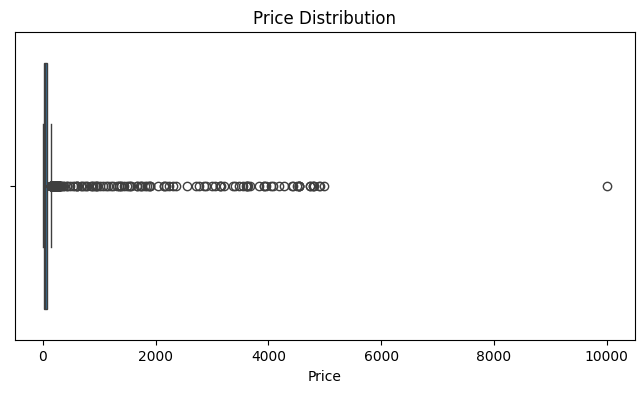

In [66]:
# Create a boxplot to view outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=creditCard['price'])
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()

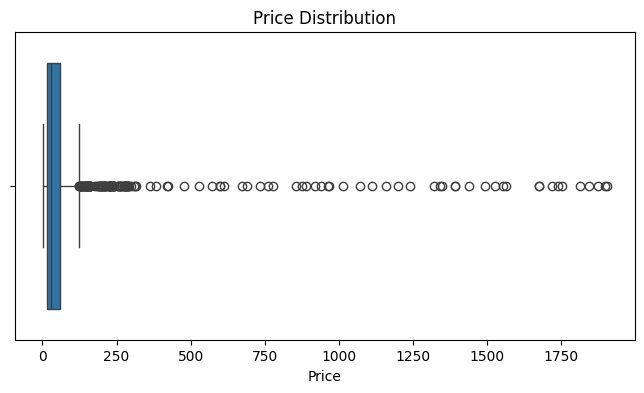

In [67]:
# Let's repeat this to view purchases under 2000
filtered_boxPlot = creditCard[creditCard['price'] <= 2000]

plt.figure(figsize=(8, 4))
sns.boxplot(x=filtered_boxPlot['price'])
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()

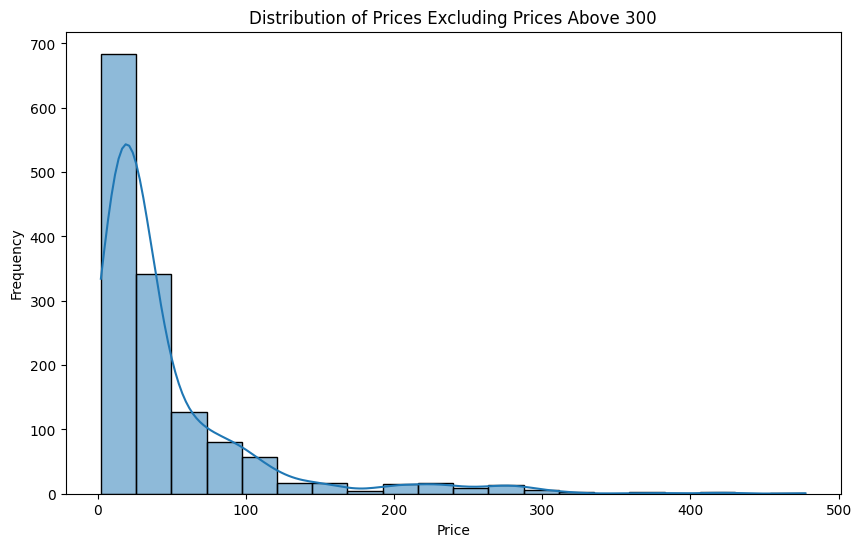

In [68]:
# Plot prices whilst excluding outliers in boxplot
filtered_creditCard = creditCard[creditCard['price'] <= 500]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_creditCard['price'], bins=20, kde=True)
plt.title('Distribution of Prices Excluding Prices Above 300')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

H2 is __rejected__ given the significant numbers of transactions above USD 500. We register a further hypothesis for the __next round__ of exploratory data analysis that the majority of expenses above USD 500 will be trade expenses. 

#### H3. Transactions are unevenly distributed and will cluster around one or more popular outlets. 

/opt/anaconda/envs/TensorFlow2/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


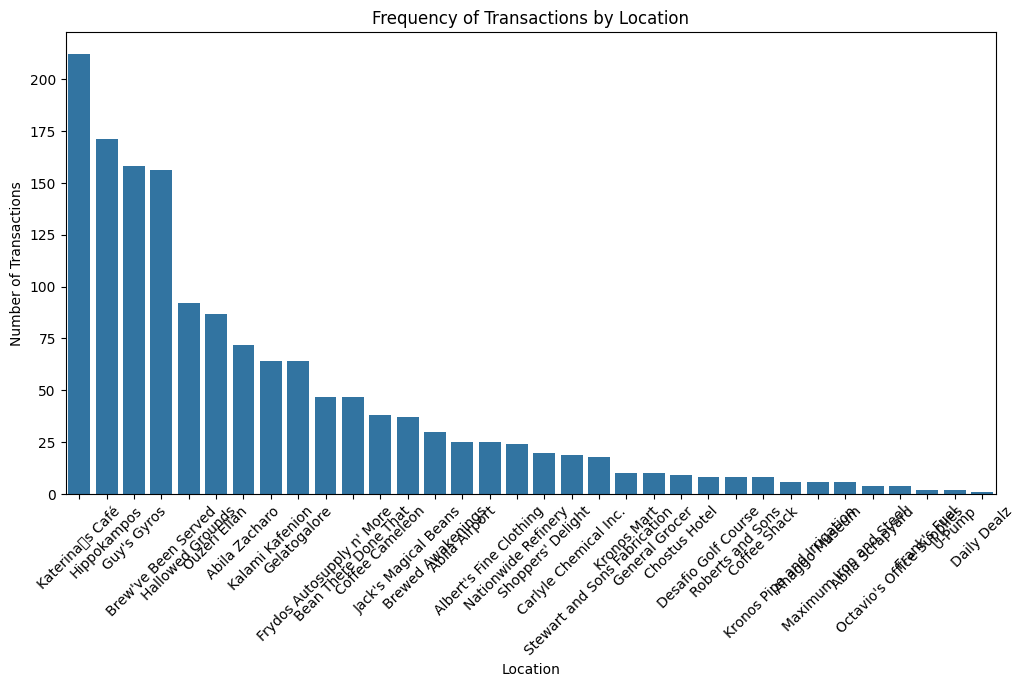

In [69]:
# Prep data for plot by grouping by location.
transaction_counts = creditCard['location'].value_counts().reset_index()
transaction_counts.columns = ['location', 'counts']
transaction_counts = transaction_counts.sort_values(by='counts', ascending=False)

# Plot 1
plt.figure(figsize=(12, 6))
sns.barplot(x='location', y='counts', data=transaction_counts)
plt.title('Frequency of Transactions by Location')
plt.xlabel('Location')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()


This __supports__ our hypotheses, but let's look at the data another way by considering the number of unique credit cards used in each location, rather than number of transactions.

/opt/anaconda/envs/TensorFlow2/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


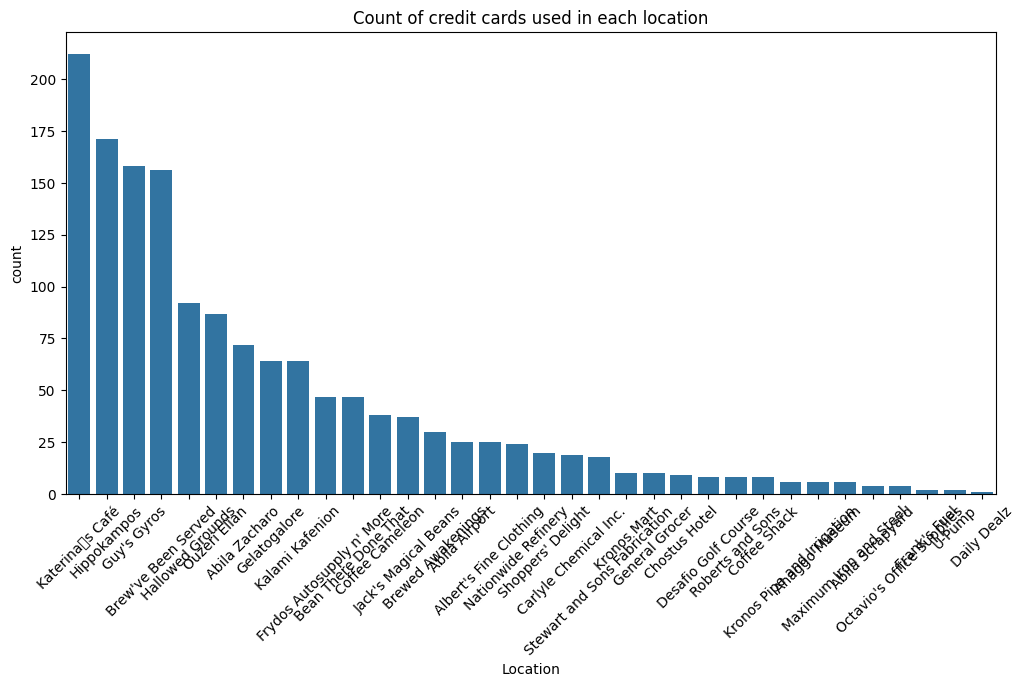

In [70]:
# How many different credit cards are used in each location?
plt.figure(figsize=(12, 6))
sns.countplot(x='location', data=creditCard, order=creditCard['location'].value_counts().index)
plt.title('Count of credit cards used in each location')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.show()

H3 is __supported__. It raises further questions about the health of businesses in the long tail of results. ___GeoJusticeLabs___ raises a further hypotheses that in these cases, the low frequency of transactions is offset by large transaction sizes.

## New Hypotheses

___GeoJusticeLabs___ registers this second round of hypotheses to guide the next stage of exploratory data analysis. 

H4. The majority of expenses above USD 500 are trade expenses. 

H5. Business transaction frequency is inversely correlated with transaction size. 

H6. The majority of travel takes place during working hours. 

H7. Several clusters of 2-5 cars will be revealed by stops in the GPS data, implying social groups. 

H8. The clearest distinction between social groups will be revealed by stops in the GPS data during weekends. 

H9. Purchase frequency and mean spend for each credit card are closely but inversely correlated. 

#### Necessary changes to data

To test some of these hypotheses, we will need to make transformations to our datasets. Some of the below changes are essential, some are for aesthetics and readibility, some are for memory optimisation.  

- Credit card data 
    - Morning, afternoon, evening, weekend derived from timestamp. 
    - Day of the week added as categorical column. 
    - Locations, credit card numbers converted to categorical. 
- Loyalty card data
    - Morning, afternoon, evening, weekend derived from timestamp.
    - Days of the week added as categoriacl column. 
    - Location and loyalty number converted to categorical. 
- Car assignments data
    - ID converted to integer and made categorical. 
    - First and last names joined and individual name columns dropped. 
    - Employment type and employment title made categorical. 
- GPS
    - ID made categorical. 
    - Timestamp converted to datetime.
    - Morning, afternoon, evening, weekend derived from timestamp. 


#### Selection, cleaning, constructing, formatting data

In [71]:
# For car assignments data, merge first and last name columns into one
carAssignments['FullName'] = carAssignments[['FirstName', 'LastName']].apply(lambda x: ' '.join(x), axis=1)
carAssignments.drop(columns=['FirstName'], inplace=True)
carAssignments.drop(columns=['LastName'], inplace=True)

In [72]:
# Impossible to merge specific truck drivers with GPS data, so converting all to generic "driver"
carAssignments.loc[carAssignments['CarID'].isna(), ['CarID', 'CurrentEmploymentType', 'CurrentEmploymentTitle', 'FullName']] = [101, 'Facilities', 'Truck Driver', 'Truck Driver']

# Updating ID values in GPS dataset
gps.loc[gps['id'] > 101, 'id'] = 101

In [73]:
# Let's merge GPS and car assignments
gps = pd.merge(gps, carAssignments, left_on='id', right_on= 'CarID', how='outer')#

# And let's drop car ID column
gps.drop(['CarID'], axis=1, inplace=True)

In [74]:
# Write function to manipulate timestamp in credit card and GPS datasets
def timestampConverter(x):
    if (x >= 3) and (x <=11):
        return 'Morning'
    elif (x >= 11) and (x <= 16):
        return 'Lunch'
    elif (x >= 16) and (x <= 20):
        return 'Evening'
    elif (x >= 20) and (x <= 24):
        return 'Night'
    elif (x > 3) and (x < 6):
        return 'Early Morning'
    
# Manipulate GPS data
gps['hour'] = pd.to_datetime(gps['Timestamp']).dt.hour
gps['time'] = gps['hour'].apply(timestampConverter)
gps['date'] = gps['Timestamp'].dt.date
gps['is_weekend'] = gps['Timestamp'].dt.dayofweek > 4

In [75]:
# Update timestamp in credit card data
creditCard['hour'] = pd.to_datetime(creditCard['timestamp']).dt.hour
creditCard['time'] = creditCard['hour'].apply(timestampConverter)
creditCard['date'] = creditCard['timestamp'].dt.date
creditCard['is_weekend'] = creditCard['timestamp'].dt.dayofweek > 4

In [76]:
# Convert columns to categorical for easier visualisation and to save memory. 
creditCard['location'] = pd.Categorical(creditCard['location'])
creditCard['last4ccnum'] = pd.Categorical(creditCard['last4ccnum'])
loyaltyCard['location'] = pd.Categorical(loyaltyCard['location'])
loyaltyCard['loyaltynum'] = pd.Categorical(loyaltyCard['loyaltynum'])
carAssignments['CurrentEmploymentType'] = pd.Categorical(carAssignments['CurrentEmploymentType'])
carAssignments['CurrentEmploymentTitle'] = pd.Categorical(carAssignments['CurrentEmploymentTitle'])

In [77]:
# Convert car assignments ID to integer to match car ID in GPS dataset
carAssignments['CarID'] = carAssignments['CarID'].fillna(0).astype(int)
carAssignments['CarID'] = carAssignments['CarID'].astype(int)

In [78]:
# Finally, let's add a column of stops
idList=np.sort(gps['id'].unique())

#making stops
for d in idList:
    data=gps[gps['id']==d].sort_values(['Timestamp'])
    
    stopList=[]
    
    for i in range(len(data['Timestamp'])-1):
        point=data['Timestamp'].iloc[i]
        nextPoint=data['Timestamp'].iloc[i+1]
    #     print(type(nextPoint-point))
        if (nextPoint-point) > dt.timedelta(minutes=3):
    #         print(nextPoint-point)
            stopList.append(1)
        else:
            stopList.append(0)

    stopList.append(0)
#     print(stopList)
    data['stop']=stopList
    if d==1:
        gpsFull=data.copy()
        dataStops=data[data['stop']==1].copy()
    else:
        gpsF=data.copy()
        gpsFull=pd.concat([gpsFull, gpsF], ignore_index=True,axis=0)
        dataS=data[data['stop']==1].copy()
        dataStops=pd.concat([dataStops, dataS], ignore_index=True,axis=0)     

In [79]:
#Send files to csv
gpsFull.to_csv('gpsFull.csv', index=False)
dataStops.to_csv('gpsStopsOnly.csv', index=False)

In [80]:
# (NB. at this point I intended to encrypt employee names with this code:)

# Generate a key and instantiate a Fernet instance
#key = Fernet.generate_key()
#cipher_suite = Fernet(key)

# Encrypt the names
#gps['encrypted name'] = gps['FullName'].apply(lambda x: cipher_suite.encrypt(x.encode())))

# Save the key
#print("Key:", key.decode()))

#### Let's check data formats are correct

In [81]:
creditCard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   1490 non-null   datetime64[ns]
 1   location    1490 non-null   category      
 2   price       1490 non-null   float64       
 3   last4ccnum  1490 non-null   category      
 4   hour        1490 non-null   int32         
 5   time        1490 non-null   object        
 6   date        1490 non-null   object        
 7   is_weekend  1490 non-null   bool          
dtypes: bool(1), category(2), datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 60.7+ KB


In [35]:
gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261905 entries, 0 to 1261904
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   Timestamp               1261905 non-null  datetime64[ns]
 1   id                      1261905 non-null  int64         
 2   lat                     1261905 non-null  float64       
 3   long                    1261905 non-null  float64       
 4   CurrentEmploymentType   1261905 non-null  object        
 5   CurrentEmploymentTitle  1261905 non-null  object        
 6   FullName                1261905 non-null  object        
 7   hour                    1261905 non-null  int32         
 8   time                    1261013 non-null  object        
 9   date                    1261905 non-null  object        
 10  is_weekend              1261905 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int32(1), int64(1), object(5)
mem

In [82]:
#### Let's view the data to make sure it's the correct format

In [83]:
dataStops

,Timestamp,id,lat,long,CurrentEmploymentType,CurrentEmploymentTitle,FullName,hour,time,date,is_weekend,stop
0,2014-01-06 07:22:04,1,36.063658,24.885866,Information Technology,IT Helpdesk,Nils Calixto,7,Morning,2014-01-06,False,1
1,2014-01-06 08:04:09,1,36.048029,24.879575,Information Technology,IT Helpdesk,Nils Calixto,8,Morning,2014-01-06,False,1
2,2014-01-06 12:26:27,1,36.076663,24.857591,Information Technology,IT Helpdesk,Nils Calixto,12,Lunch,2014-01-06,False,1
3,2014-01-06 13:34:27,1,36.048029,24.879572,Information Technology,IT Helpdesk,Nils Calixto,13,Lunch,2014-01-06,False,1
4,2014-01-06 17:48:03,1,36.066487,24.882602,Information Technology,IT Helpdesk,Nils Calixto,17,Evening,2014-01-06,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3036,2014-01-17 10:29:34,101,36.054184,24.908087,Facilities,Truck Driver,Truck Driver,10,Morning,2014-01-17,False,1
3037,2014-01-17 11:03:01,101,36.054119,24.908106,Facilities,Truck Driver,Truck Driver,11,Morning,2014-01-17,False,1
3038,2014-01-17 11:39:16,101,36.048054,24.879575,Facilities,Truck Driver,Truck Driver,11,Morning,2014-01-17,False,1
3039,2014-01-17 12:44:25,101,36.058178,24.885506,Facilities,Truck Driver,Truck Driver,12,Lunch,2014-01-17,False,1


### New hypotheses and second round of exploratory data analysis

#### H4. The majority of expenses above USD 500 are trade expenses. 

/tmp/ipykernel_65244/2883811404.py:14: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
/opt/anaconda/envs/TensorFlow2/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


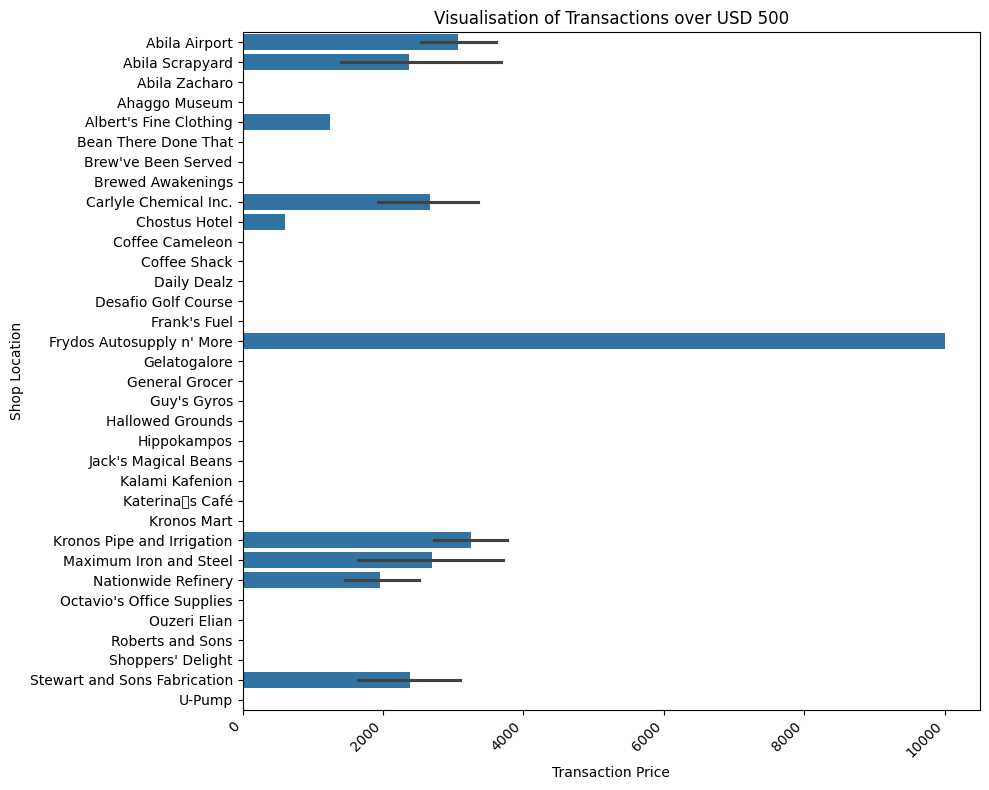

In [84]:
# Filter for transactions above USD 500
highValueCcSpend = creditCard[creditCard['price'] > 500]

#Sort data by location
highValueCcSpend_sorted = highValueCcSpend.sort_values('location')

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='price', y='location', data=highValueCcSpend_sorted)
plt.title('Visualisation of Transactions over USD 500')
plt.xlabel('Transaction Price')
plt.ylabel('Shop Location')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

H4 is __supported__. Transactions at retailer 'Albert's Fine Clothing' are the exception and merit further investigation. 

#### H5. Retail outlets with low frequency of trading have higher average transaction sizes.

/tmp/ipykernel_65244/3974776448.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tradeSizeVsFrequency = creditCard.groupby('location').agg({


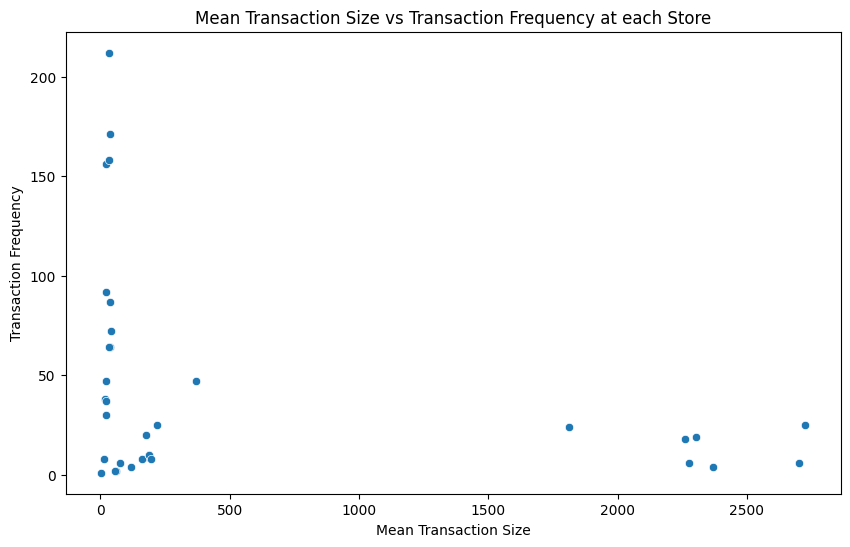

In [85]:
# Group by location and calculate mean price and count of transactions. 
tradeSizeVsFrequency = creditCard.groupby('location').agg({
    'price': 'mean',
    'last4ccnum': 'count'
}).rename(columns={'price': 'Mean Transaction Size', 'last4ccnum': 
'Transaction Frequency'})

#Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mean Transaction Size', y='Transaction Frequency', data=tradeSizeVsFrequency)
plt.title('Mean Transaction Size vs Transaction Frequency at each Store')
plt.xlabel('Mean Transaction Size')
plt.ylabel('Transaction Frequency')
plt.show()


H5 is __supported__. The visualisation suggests three broad family of outlets, each with a slightly different relationship between frequency and price, but overall supporting the hypotheses. Value at transaction size c. 440 merits further investigation. 

#### H6. The majority of travel takes place during working hours. 

This might seem like a statement of the obvious but it is important for us to rule out shift work which might see employees travelling at unusual times of day being suspects unnecessarily. 

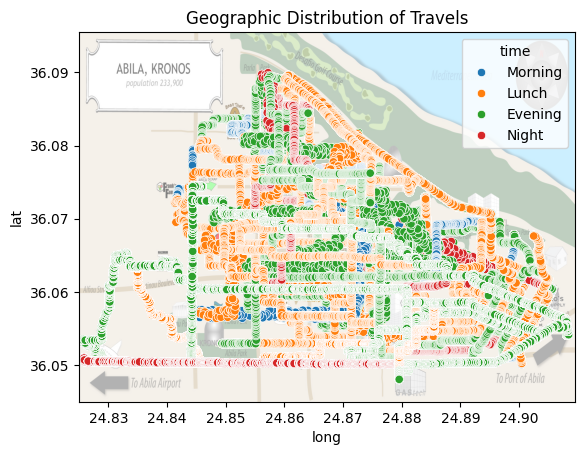

In [86]:
# How does travel vary by time of day? 
sns.scatterplot(x='long', y='lat', hue='time', data=gps)
img=plt.imread("MC2-tourist.jpg")
plt.imshow(img, extent=[24.825, 24.9095, 36.045, 36.0955], alpha = 0.5, aspect='auto')
plt.title('Geographic Distribution of Travels')
plt.show()

H6 is __provisionally visually supported__. The bulk of movement appears to take place during lunch and in the evening. However, the visualisation demands a further piece of work:
- Filter GPS timestamps in the morning and night. 
- Plot them by hour. 
- Visualise their travel. 

It also suggests a further hypothesis to test: "the GPS stamps in red are exclusively trade traffic."

#### H7. Several clusters of 2-5 cars will be revealed by stops in the GPS data, implying social groups.  

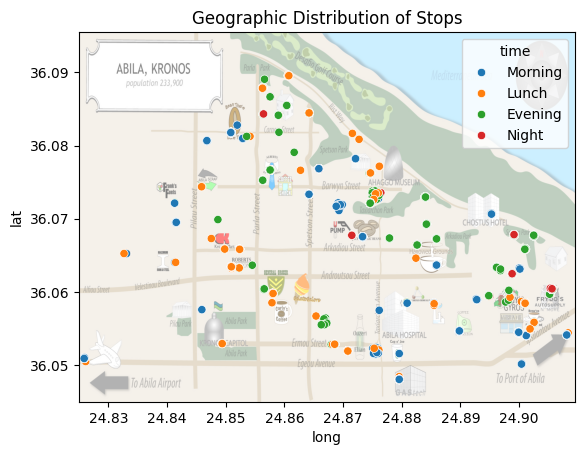

In [87]:
# How do stops vary by time of day?
sns.scatterplot(x='long', y='lat', hue='time', data=dataStops)
img=plt.imread("MC2-tourist.jpg")
plt.imshow(img, extent=[24.825, 24.9095, 36.045, 36.0955], alpha = 0.5, aspect='auto')
plt.title('Geographic Distribution of Stops')
plt.show()

H7 is __supported__. However, it suggests further work to examine whether individual clusters are consistent over time. It raises a further hypothesis: "A majority of car clusters repeat across weekends." 

#### H8. The clearest distinction between social groups will be between social groups at the weekend. 

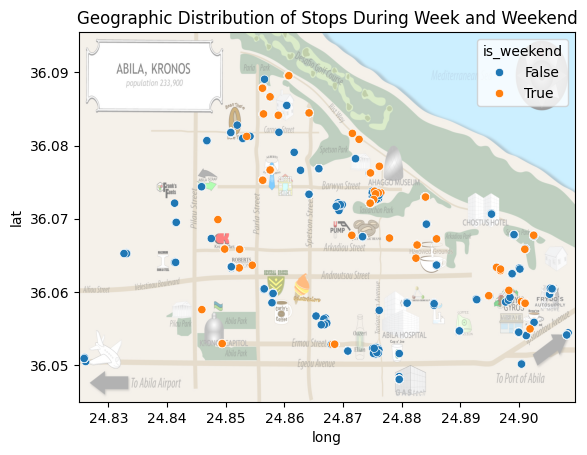

In [88]:
# How do stops vary by time of day?
sns.scatterplot(x='long', y='lat', hue='is_weekend', data=dataStops)
img=plt.imread("MC2-tourist.jpg")
plt.imshow(img, extent=[24.825, 24.9095, 36.045, 36.0955], alpha = 0.5, aspect='auto')
plt.title('Geographic Distribution of Stops During Week and Weekend')
plt.show()

H8 is __provisionally rejected__. Visual inspection suggested the clusters revealed at the weekend are no greater than clusters during week. Explanations could include individuals walking or taking public transport at weekend. Requires confirmation with a clustering approach using credit card data. 

## __Modeling__

The investigation so far has revealed several leads that are set out at the end of this document. However, ___GeoDataLabs___ proposes two final analytic approaches to identifying outliers for further investigation by local law enforcement. 

__Regression__. It is assumed that every GasTech employee has a finite budget. Therefore, (H9) purchase size will decrease as frequency increases. Put simply, if you spend more frequently you will have to spend less. A regression will identify those to whom this rule doesn't apply and who may have an unexplained source of an additional income.  

__Local Outlier Factor__. We will use a machine learning method to survey the totality of the travel data and compute the outliers that may not have been obvious to our analysts. 

#### Regression

/tmp/ipykernel_65244/1269720744.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dailySpendByCard = filteredCreditCard.groupby('last4ccnum').agg({


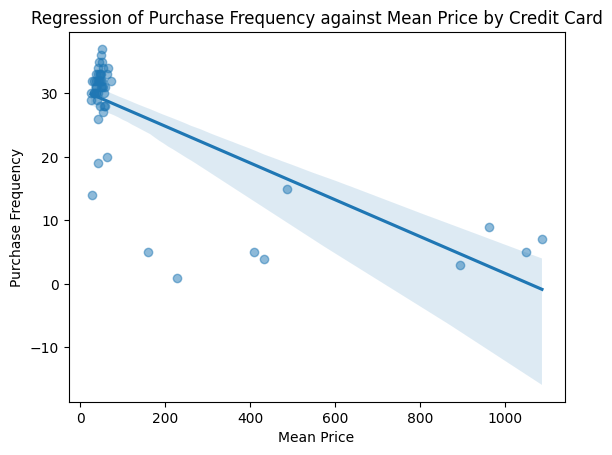

In [89]:
# Filter for consumer transactions by taking largest consumer price from H4 as upper fence
filteredCreditCard = creditCard[creditCard['price'] <= 1600]

dailySpendByCard = filteredCreditCard.groupby('last4ccnum').agg({
    'price': 'mean',
    'last4ccnum': 'count'
}).rename(columns={'price': 'mean price', 'last4ccnum': 'Purchase frequency'})

sns.regplot(x='mean price', y='Purchase frequency', data=dailySpendByCard, scatter_kws={'alpha':0.5})

plt.title('Regression of Purchase Frequency against Mean Price by Credit Card')
plt.xlabel('Mean Price')
plt.ylabel('Purchase Frequency')
plt.show()

This regression __supports__ the expected trend. The outliers at c. 950 and c. 1050 on the x-axis are candidates for further investigation.  

#### Local outlier factor

This method will use machine learning to compute differences between multiple datapoints that it would have been impossible for our analysts to achieve in the time available. It will illuminate vehicle stops which are __uncharacteristic__ in comparison to the rest of the data. 

In [90]:
# Outlier detection using Local Outlier Factor (LOF)

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Convert datetime to Unix timestamp
dataStops['Timestamp'] = dataStops['Timestamp'].apply(lambda x: x.timestamp())

# Cast to float64
dataStops['Timestamp'] = dataStops['Timestamp'].astype('float64')

# Convert boolean 'weekend' to int (True=1, False=0)
dataStops['is_weekend'] = dataStops['is_weekend'].astype(int)

dataStops.head()


,Timestamp,id,lat,long,CurrentEmploymentType,CurrentEmploymentTitle,FullName,hour,time,date,is_weekend,stop
0,1.388993e+09,1,36.063658,24.885866,Information Technology,IT Helpdesk,Nils Calixto,7,Morning,2014-01-06,0,1
1,1.388995e+09,1,36.048029,24.879575,Information Technology,IT Helpdesk,Nils Calixto,8,Morning,2014-01-06,0,1
2,1.389011e+09,1,36.076663,24.857591,Information Technology,IT Helpdesk,Nils Calixto,12,Lunch,2014-01-06,0,1
3,1.389015e+09,1,36.048029,24.879572,Information Technology,IT Helpdesk,Nils Calixto,13,Lunch,2014-01-06,0,1
4,1.389030e+09,1,36.066487,24.882602,Information Technology,IT Helpdesk,Nils Calixto,17,Evening,2014-01-06,0,1


In [91]:
# Prepare the dataset for LOF
features = dataStops[['lat', 'long', 'Timestamp', 'is_weekend']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply local outlier factor
lof = LocalOutlierFactor(n_neighbors=20)
outlier_flags = lof.fit_predict(scaled_features)

# Add outlier flags to the original data
dataStops['outlier'] = outlier_flags

# Display outliers
outliers = dataStops[dataStops['outlier'] == -1]
print(outliers)

         Timestamp   id        lat       long   CurrentEmploymentType  \
8     1.389047e+09    1  36.048022  24.879570  Information Technology   
9     1.389049e+09    1  36.048025  24.879573  Information Technology   
26    1.389216e+09    1  36.048056  24.879572  Information Technology   
27    1.389217e+09    1  36.048031  24.879568  Information Technology   
74    1.389825e+09    1  36.048030  24.879577  Information Technology   
...            ...  ...        ...        ...                     ...   
3033  1.389902e+09  101  36.048039  24.879568              Facilities   
3034  1.389906e+09  101  36.048074  24.879565              Facilities   
3036  1.389955e+09  101  36.054184  24.908087              Facilities   
3037  1.389957e+09  101  36.054119  24.908106              Facilities   
3038  1.389959e+09  101  36.048054  24.879575              Facilities   

     CurrentEmploymentTitle      FullName  hour     time        date  \
8               IT Helpdesk  Nils Calixto    22    

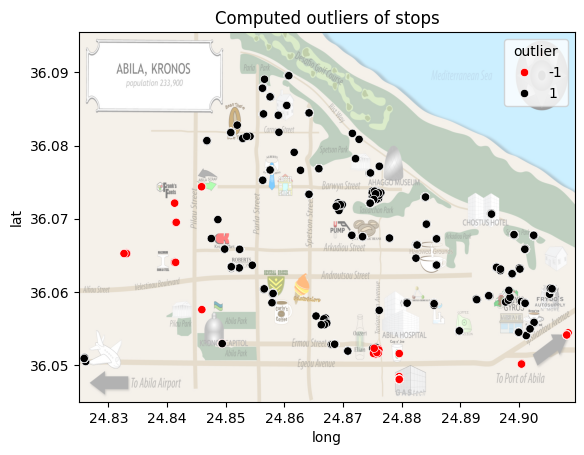

In [92]:
# Let's visualise this

# Set the color palette for hue mapping
colors = {-1: 'red', 1: 'black'}

# Let's create the plot
sns.scatterplot(x='long', y='lat', hue='outlier', palette=colors, data=dataStops)
img=plt.imread("MC2-tourist.jpg")
plt.imshow(img, extent=[24.825, 24.9095, 36.045, 36.0955], alpha = 0.5, aspect='auto')
plt.title('Computed outliers of stops')
plt.show()

The Local Outlier Factor method has provided leads for further investigation (illustrated in red). __GeoJusticeLabs__ caveats this by saying all of these leads require validation against other characteristics in the data. 

## Recommmendations

#### Further hypotheses testing. 

___GeoJusticeLabs___ has been able to establish a general pattern of life for the island in terms of travel and spending. However, it has been unable to investigate the characteristics of _exceptions_ to these patterns. We would recommend a third round of exploratory data analysis, particularly looking at clusters of spending and travel which are one or two standard deviations from the norm. We would work to the following hypotheses:
- Travel in the early morning and late evening is exclusively trade traffic (this would explain the exceptions from H6). 
- Spending is positively correlated with occupation (this would explain the exceptions from the regression exercise and H2, H4, H5).

#### Further data wrangling. 

With current resourcing, we were unable to join the transaction data with the GPS data. Joining the two will be required to test H2, H4, and H5. So we recommend additional resource (1 x data analyst) to achieve this.  

#### Preliminary recommendations to law enforcement. 

___GeoJusticeLabs___ is already able to make the following recommendations to law enforcement based on our understanding of the Island's pattern of life:
- Investigate a small number of suspicious transactions between 0200 and 0300 in the morning. 
- Investigate a single significant outlier transaction of USD 10,000. 
- Investigate recent purchases at Albert's Fine Clothing which are statistically unlikely given the Island Population's overall spending. 

#### Sharing data in an ethical and secure way with law enforcement

Names would be selectively de-anonymized after internal consideration and passed to law enforcement when we internally agree that the probability of a lead being useful and valid is high. We would use the following code to do it: 

In [ ]:
#gps['decrypted_name'] = gps['encrypted_name'].apply(lambda x:
#cipher_suite.decrypt(x).decode())